<a href="https://colab.research.google.com/github/celaira/roof_deep_learning/blob/main/dida_testtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Images:**

### mount google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import stuff

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, InputLayer


### create path to data:

In [3]:
training_image_path = '/content/drive/MyDrive/training_image'
label_path = '/content/drive/MyDrive/label'
test_image_path = '/content/drive/MyDrive/test_image'

### import the images:

In [4]:
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return np.array(images), filenames

train_images, train_image_filenames = load_images_from_folder(training_image_path)
labels, label_filenames = load_images_from_folder(label_path)
test_images, test_image_filenames = load_images_from_folder(test_image_path)

# Ensure the training images and labels are aligned by sorting the filenames
train_image_filenames_sorted = sorted(train_image_filenames)
label_filenames_sorted = sorted(label_filenames)

aligned_train_images = [cv.imread(os.path.join(training_image_path, filename)) for filename in train_image_filenames_sorted]
aligned_labels = [cv.imread(os.path.join(label_path, filename), cv.IMREAD_GRAYSCALE) for filename in label_filenames_sorted]

# Convert to numpy arrays
aligned_train_images = np.array(aligned_train_images)
aligned_labels = np.array(aligned_labels)
test_images = np.array(test_images)

# Normalize the images
aligned_train_images = aligned_train_images / 255.0
aligned_labels = aligned_labels / 255.0
test_images = test_images / 255.0


### Creating validation for better error-testing:

In [5]:
# Binarize the labels
aligned_labels = np.where(aligned_labels > 0.5, 1, 0)

# Add an extra dimension to the data
aligned_train_images = aligned_train_images[..., np.newaxis]
aligned_labels = aligned_labels[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Split training and validation data
train_images, val_images, train_labels, val_labels = train_test_split(aligned_train_images, aligned_labels, test_size=0.2, random_state=42)


# **Define a UNET-Model:**

unet_model is a function that takes input_shape as an argument, which defines the shape of the input images (e.g., height, width, and number of channels).

layers.Input creates a Keras tensor, which will act as the input layer of the model. The shape of this input is defined by input_shape.

In [15]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    p5 = layers.MaxPooling2D((2, 2))(c5)

    # Bottleneck
    c6 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    c6 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(c6)

    # Decoder
    u7 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c5])
    c7 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c4])
    c8 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c3])
    c9 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = layers.concatenate([u10, c2])
    c10 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c10)

    u11 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = layers.concatenate([u11, c1])
    c11 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u11)
    c11 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c11)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(c11)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# **Train Model:**

In [7]:
input_shape = (train_images.shape[1], train_images.shape[2], train_images.shape[3])
model = unet_model(input_shape)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
num_classes = 2  #2 classes: roof and non-roof
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)
val_labels_cat = to_categorical(val_labels, num_classes=num_classes)
history = model.fit(train_images, train_labels_cat, epochs=20, batch_size=5, validation_data=(val_images, val_labels_cat))
model.save('/content/drive/MyDrive/save')
#val_loss, val_accuracy = model.evaluate(val_images, val_labels)

Epoch 1/20


KeyboardInterrupt: 

# **Predictions and Visualization of them :**

1/1 [==============================] - 9s 9s/step


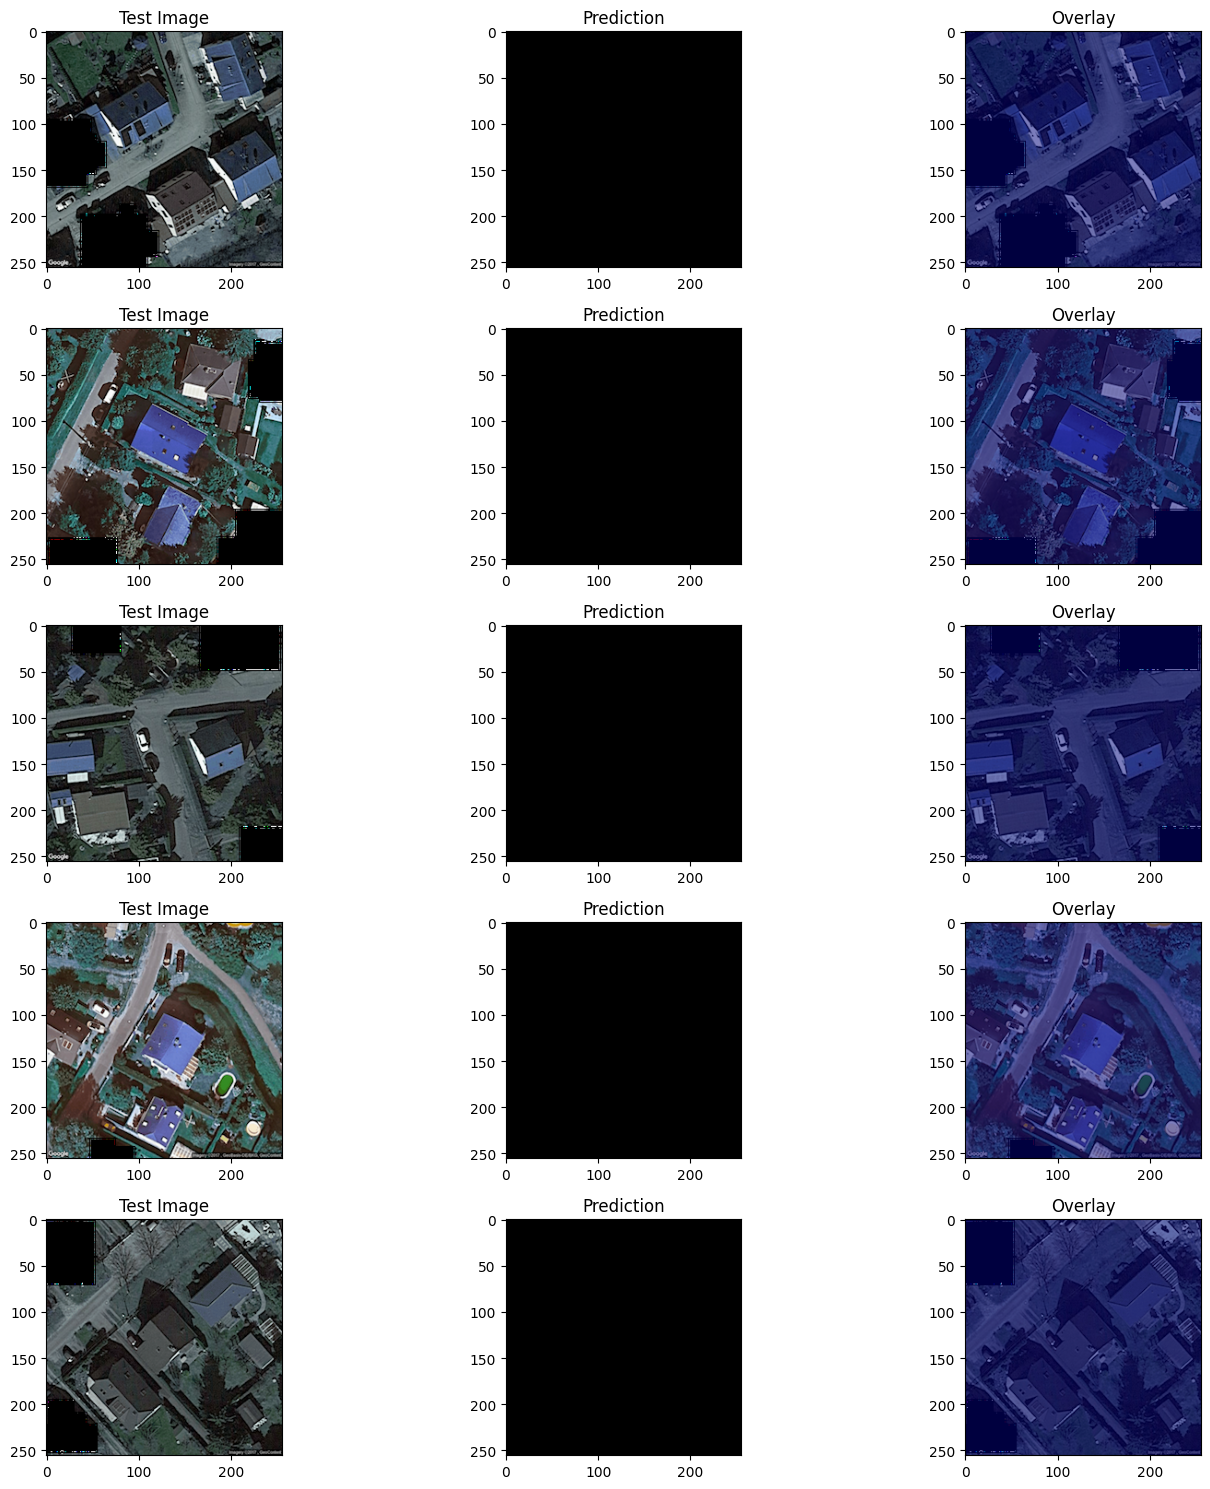

In [9]:
predictions = model.predict(test_images)
predictions_path = '/content/drive/MyDrive/predictions'
os.makedirs(predictions_path, exist_ok=True)

for i, pred in enumerate(predictions):
    pred_mask = np.argmax(pred, axis=-1)  # Convert softmax probabilities to class labels
    pred_mask = (pred_mask * 255).astype(np.uint8)  # Convert to 8-bit integer (0 to 255)
    pred_mask = np.squeeze(pred_mask)  # Ensure the mask is single-channel
    cv.imwrite(os.path.join(predictions_path, f'prediction_{i}.png'), pred_mask)

# Display predictions for the first 5 test images
def display_predictions(test_images, predictions, num=5):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title("Test Image")

        plt.subplot(num, 3, i*3 + 2)
        pred_mask = np.argmax(predictions[i], axis=-1)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction")

        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.imshow(pred_mask, cmap='jet', alpha=0.5)
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

# Display predictions
display_predictions(test_images, predictions, num=5)

# **TRASH:**

In [ ]:
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

train_image = np.array(load_images_from_folder(training_image_path))
label = np.array(load_images_from_folder(label_path))
test_image = np.array(load_images_from_folder(test_image_path))

#normalization
train_image = np.array(train_image) / 255.0
label = np.array(label) / 255.0
test_image = np.array(test_image) / 255.0

In [ ]:
#binarize the labels
labels = np.where(labels > 0.5, 1, 0)

#needed for keras -> need to look it up again
train_images = train_images[..., np.newaxis]
labels = labels[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# split training and validation -> nicht ganz verstanden
train_images, val_images, train_labels, val_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)

Sequential model define (simple):

In [ ]:
from tensorflow.keras.models import Sequential
model = Sequential()
#Encodes
model.add(InputLayer(input_shape=aligned_train_images.shape[1:]))
print(aligned_train_images.shape)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model.add(Conv2DTranspose(512, (2, 2), strides=(2, 2), activation='relu', padding='same'))

model.add(Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu', padding='same'))

model.add(Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu', padding='same'))

model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same'))

# Output layer
model.add(Conv2D(1, (1, 1), activation='sigmoid'))